In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import csv
import os

In [2]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
validation_dir = os.path.join(os.getcwd(), 'validation')

### Mobilenet PRETRAIN MODEL Base

In [3]:
img_size = 224

mobilenet_base = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                             include_top=False,
                                                             input_shape=(img_size, img_size, 3))

In [4]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Feature Extraction

In [5]:
# features shape need to follow model last layer
# Need to add a comma and 10 for labels shape as there are 10 classes for the dataset

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1280))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = mobilenet_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

Found 7500 images belonging to 10 classes.
1/1 [==============================] - 1s 580ms/step
Found 2000 images belonging to 10 classes.
1/1 [==============================] - 0s 36ms/step
Found 500 images belonging to 10 classes.
1/1 [==============================] - 0s 38ms/step


In [7]:
print(train_features.shape)
print(train_labels.shape)

(7500, 7, 7, 1280)
(7500, 10)


In [8]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 1280))
test_features = np.reshape(test_features, (500, 7 * 7 * 1280))

### Test 1: Unfreezing last 2 layers (No point unfreezing just last layer as it has 0 params)

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

mobilenet_base.trainable = True

set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name == 'Conv_1_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
mobilenet = models.Sequential()
mobilenet.add(mobilenet_base)
mobilenet.add(layers.Flatten())
mobilenet.add(layers.Dense(256, activation='relu'))
mobilenet.add(layers.Dense(10, activation='softmax'))

In [12]:
mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 18,317,130
Trainable params: 16,061,706
Non-trainable params: 2,255,424
_________________________________________________________________


In [13]:
mobilenet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [15]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'mobilenet_finetuning_1.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = mobilenet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 2.1580 - acc: 0.6028
Epoch 1: val_loss improved from inf to 0.89562, saving model to mobilenet_finetuning_1.keras
235/235 [==============================] - 88s 365ms/step - loss: 2.1580 - acc: 0.6028 - val_loss: 0.8956 - val_acc: 0.7345
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.8940 - acc: 0.7228
Epoch 2: val_loss improved from 0.89562 to 0.83248, saving model to mobilenet_finetuning_1.keras
235/235 [==============================] - 96s 410ms/step - loss: 0.8940 - acc: 0.7228 - val_loss: 0.8325 - val_acc: 0.7550
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.7724 - acc: 0.7593
Epoch 3: val_loss improved from 0.83248 to 0.81684, saving model to mobilenet_finetuning_1.keras
235/235 [==============================] - 92s 391ms/step - loss: 0.7724 - acc: 0.7593 - val_loss: 0.8168 - val_acc: 0.7635
Epoch 4/30
235/235 [==============================] - ETA: 0s - loss

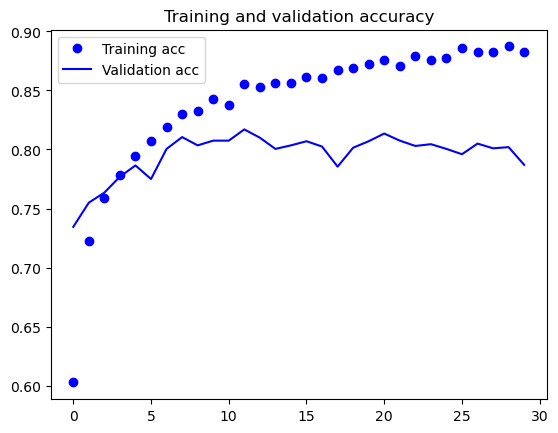

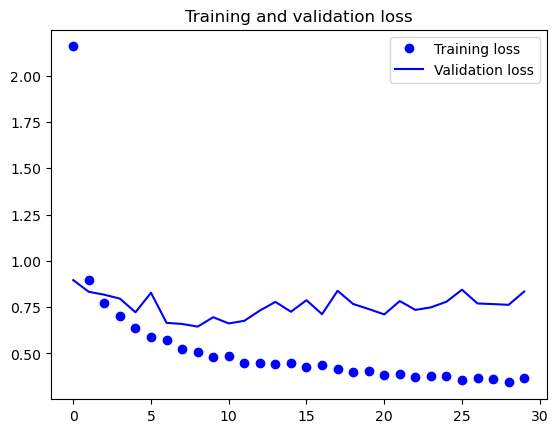

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Test 2: Unfreezing last 3 layers

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

mobilenet_base.trainable = True

set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name == 'Conv_1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [19]:
mobilenet = models.Sequential()
mobilenet.add(mobilenet_base)
mobilenet.add(layers.Flatten())
mobilenet.add(layers.Dense(256, activation='relu'))
mobilenet.add(layers.Dense(10, activation='softmax'))

In [20]:
mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16056576  
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 18,317,130
Trainable params: 16,471,306
Non-trainable params: 1,845,824
_________________________________________________________________


In [21]:
mobilenet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [22]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [23]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'mobilenet_finetuning_2.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = mobilenet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 1.7760 - acc: 0.6477
Epoch 1: val_loss improved from inf to 0.97201, saving model to mobilenet_finetuning_2.keras
235/235 [==============================] - 78s 326ms/step - loss: 1.7760 - acc: 0.6477 - val_loss: 0.9720 - val_acc: 0.7390
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.7958 - acc: 0.7556
Epoch 2: val_loss improved from 0.97201 to 0.81568, saving model to mobilenet_finetuning_2.keras
235/235 [==============================] - 75s 320ms/step - loss: 0.7958 - acc: 0.7556 - val_loss: 0.8157 - val_acc: 0.7760
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.6898 - acc: 0.7920
Epoch 3: val_loss did not improve from 0.81568
235/235 [==============================] - 74s 314ms/step - loss: 0.6898 - acc: 0.7920 - val_loss: 1.0056 - val_acc: 0.7500
Epoch 4/30
235/235 [==============================] - ETA: 0s - loss: 0.6048 - acc: 0.8111
Epoch 4: val_loss did not i

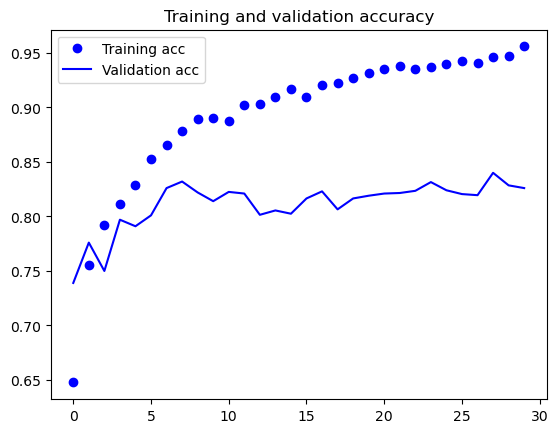

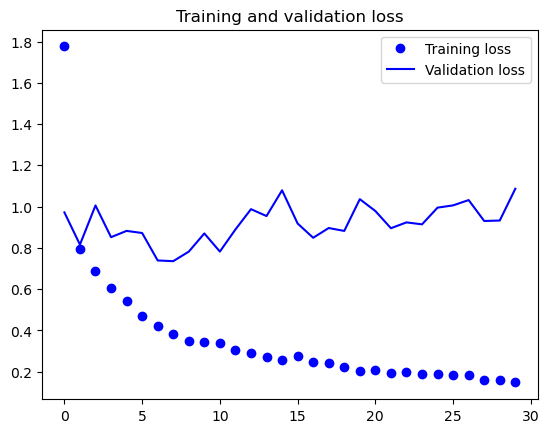

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()